pip install pyshp: necessary command to get pyshp library into jupyter

In [1]:
import shapefile # import shapefile library
fname = 'sinuosity_shapefiles/sin_CM1.shp'

each shapefile contains polylines of the channel in question for each year that it was analysed. CM1-3 and 6 are analysed for 2000 - 2017, CM5 for 2012 - 2017 and CM7 for 2009 - 2017

In [2]:
reader = shapefile.Reader(fname) # reads in shapefile identified above
shps = reader.shapes() # reads all polylines within shapefile
#/sinuosity_shapefiles/sin_CM6.shp
print([shp.shapeTypeName for shp in shps]) # shows number of polylines in shapefile

['POLYLINE', 'POLYLINE', 'POLYLINE', 'POLYLINE', 'POLYLINE', 'POLYLINE', 'POLYLINE']


In [3]:
#find out year of each polyline so that when called can display it
for i in range(reader.numRecords):
    years = reader.shapeRecord(i)
    print(list(years.record))

[2012, 2012, None]
[2017, 2017, None]
[2006, 2006, None]
[2000, 2000, None]
[2014, 2014, None]
[2009, 2009, None]
[2004, 2004, None]


plot a channel and convert from lat-lon to degrees

In [4]:
pshps = [ shp.points for shp in shps ] # list of all vertices in polyline being analysed

In [5]:
%matplotlib inline 
from matplotlib import pyplot as plt

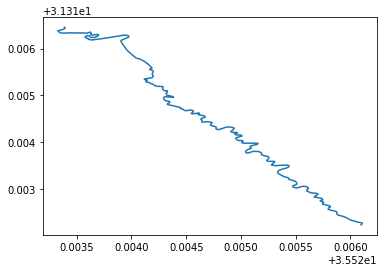

In [6]:
pshp = pshps[0]
lngs, lats = list(zip(*pshp)) # reorder the points into lat and lon columns using zip
plt.plot(lngs, lats) # plot with lat correct

In [9]:
import math

# bodge converting from lat-lon to metres by using earth as a sphere
def convertlatlngtoxy(lats, lngs):
    lng0, lat0 = lngs[0], lats[0]
    earthrad = 6378137
    nyfac = 2*math.pi*earthrad/360
    exfac = nyfac*math.cos(math.radians(lat0))
    xs = [(lng - lng0)*exfac  for lng in lngs]  
    ys = [(lat - lat0)*nyfac  for lat in lats]  
    return xs, ys

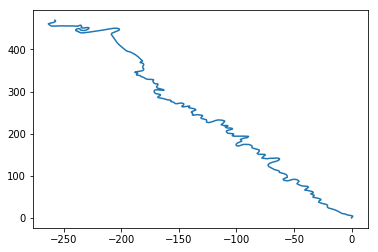

In [10]:
xs, ys = convertlatlngtoxy(lats, lngs)
plt.plot(xs, ys)

We start the pandas work here.

pandas is a tool which allows for easy data manipulation and analysis. it has some cool shortcuts and tricks built in.


In [11]:
import pandas as pd

# select the polyline from the shapefile that you wish to investigate ie the year

pshp = pshps[0] 
lngs, lats = list(zip(*pshp))
df = pd.DataFrame({"lat":lats, "lng":lngs}) # dataframe equivalent of matrix/array in matlab
lat0, lng0 = df.lat.iloc[0], df.lng.iloc[0]


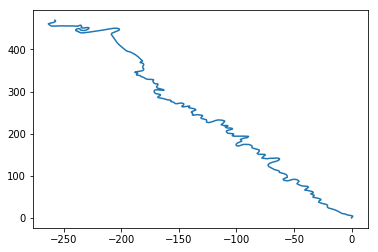

In [12]:
# This should properly be done with Proj4 or something
# but we bodge it using earth as a sphere
earthrad = 6378137
nyfac = 2*math.pi*earthrad/360
exfac = nyfac*math.cos(math.radians(lat0))
df["x"] = (df.lng - lng0)*exfac
df["y"] = (df.lat - lat0)*nyfac
plt.plot(df.x, df.y)

make a tapered moving window which has a certain centre-point and radius (width)

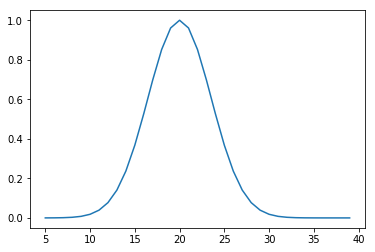

In [13]:
import numpy as np
centreweightindex = 20
centreweightrad = 5
def makeweightseries(centreweightindex, centreweightrad):
    indexcolumn = df.index.to_series()
    w = np.exp(-((indexcolumn - centreweightindex)/centreweightrad)**2)
    return w
w = makeweightseries(centreweightindex, centreweightrad)
plt.plot(w.iloc[5:40])

apply moving window to stream channel path to calculate 'line of least resistance ie valley slope

Really we should do this only for the final dataet in the time series (ie the position of the channel in 2017) and then use this 'valley slope' for all of the years of the channels

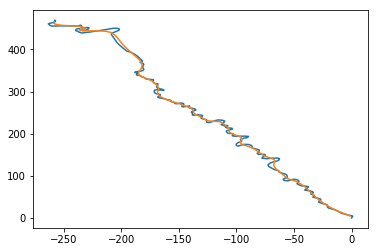

In [14]:
wxs, wys = [ ], [ ]
centreweightrad = 5
for centreweightindex in range(len(df.x)):
    w = makeweightseries(centreweightindex, centreweightrad)
    wx = sum(w*df.x)/sum(w)
    wy = sum(w*df.y)/sum(w)
    wxs.append(wx)
    wys.append(wy)
plt.plot(df.x, df.y)
plt.plot(wxs, wys)

In [15]:
# stream vector
sx = df.x.iloc[-1] - df.x.iloc[0]
sy = df.y.iloc[-1] - df.y.iloc[0]
slen = math.sqrt(sx**2 + sy**2)
sx, sy = sx/slen, sy/slen
sx, sy  # unit vector

(-0.4813001138689534, 0.8765558740831827)

In [16]:
df["vx"] = (df.x.shift(-1) - df.x)
df.vx.iloc[-1] = 0  # force the final nan to be zero
df["vy"] = (df.y.shift(-1) - df.y)
df.vy.iloc[-1] = 0
df["segleng"] = np.sqrt(df.vx**2 + df.vy**2)


In [17]:
weightedstreamlength = sum(df.segleng*w)/sum(w)
weighteddirectlength = sum(df.vx*sx*w+df.vy*sy*w)/sum(w)
weightedsinuosity = weightedstreamlength/weighteddirectlength
weightedsinuosity # average sinuosity of the entire 


1.7692983909102897

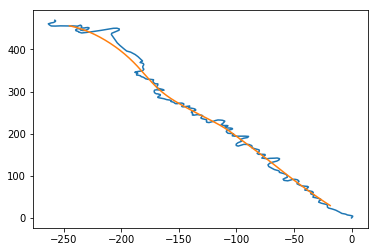

In [18]:
wxs, wys = [ ], [ ]
wsin = [ ]
centreweightrad = 25
for centreweightindex in range(len(df.x)):
    w = makeweightseries(centreweightindex, centreweightrad)
    
    wx = sum(w*df.x)/sum(w)
    wy = sum(w*df.y)/sum(w)
    
    weightedstreamlength = sum(df.segleng*w)/sum(w)
    weighteddirectlength = sum(df.vx*sx*w+df.vy*sy*w)/sum(w)
    weightedsinuosity = weightedstreamlength/weighteddirectlength
    wsin.append(weightedsinuosity)
    wxs.append(wx)
    wys.append(wy)
    
wxs = np.array(wxs)
wys = np.array(wys)
awsin = np.array(wsin)
plt.plot(df.x, df.y)
plt.plot(wxs, wys)

In [19]:
a = [1,2,3,4,54]
np.array(a) + 1000

array([1001, 1002, 1003, 1004, 1054])

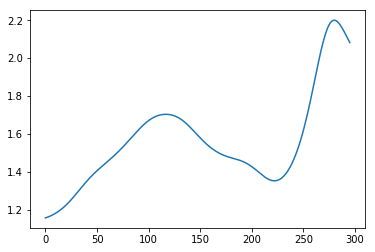

In [20]:
plt.plot(awsin)
# sinuosity as a function of distance along channel


In [21]:
awsin.min(), awsin.max()

(1.1578718012316054, 2.1998145517489203)

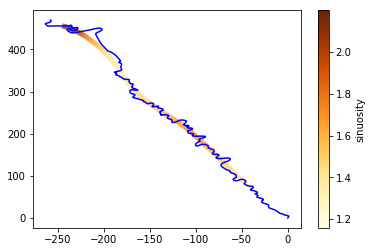

In [22]:
# use https://matplotlib.org/gallery/lines_bars_and_markers/multicolored_line.html
from matplotlib.collections import LineCollection
points = np.array([wxs, wys]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
awsin = np.array(wsin)
norm = plt.Normalize(awsin.min(), awsin.max())
lc = LineCollection(segments, cmap='YlOrBr', norm=norm)
lc.set_array(awsin)
lc.set_linewidth(5)
#cm = plt.get_cmap("winter")
fig, axs = plt.subplots(1, 1)
ax = axs

line = ax.add_collection(lc)
#segments
#plt.show()
#ax.gca()

#ax.set_xlim(min(wxs), max(wxs))
#ax.set_ylim(min(wys), max(wys))
fig.colorbar(line, ax=axs, label="sinuosity")
plt.plot(df.x, df.y, color="blue")

plt.show()


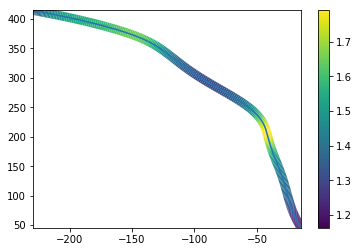

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

x = np.array(wxs)
y = np.array(wys)
dydx = awsin



# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(1, 1)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(9)
line = axs.add_collection(lc)
fig.colorbar(line, ax=axs)

axs.set_xlim(x.min(), x.max())
axs.set_ylim(y.min(), y.max())

plt.plot(x, y)
plt.show()
